### Assignment 3 Open cv

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import json
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

E:\Others\Machine Learning\Python-venv\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
MODEL_PATH = 'student_recognition_mobilenet.h5'
CLASS_INDICES_PATH = 'class_indices.json'

CONFIDENCE_THRESHOLD = 70.0

In [3]:
print("Loading model...")
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded")

print("Loading class indices...")
with open(CLASS_INDICES_PATH, 'r') as f:
    class_indices = json.load(f)

index_to_class = {v: k for k, v in class_indices.items()}
print(f"Loaded {len(index_to_class)} student classes")

Loading model...


Model loaded
Loading class indices...
Loaded 79 student classes


In [5]:
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
)
print("Face detector loaded")

Face detector loaded


In [7]:
def predict_student(face_img):
    face_resized = cv2.resize(face_img, (224, 224))
    face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)
    face_array = np.expand_dims(face_rgb, axis=0)
    face_array = preprocess_input(face_array.astype('float32'))
    predictions = model.predict(face_array, verbose=0)
    predicted_index = np.argmax(predictions[0])
    confidence = predictions[0][predicted_index] * 100
    student_id = index_to_class[predicted_index]
    return student_id, confidence

print("Prediction function ready")

Prediction function ready


In [11]:
print("STUDENT ID PREDICTION - WEBCAM")
print("\nControls:")
print("  [Q] - Quit")
print("  [S] - Save screenshot")
print("="*50)

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Cannot open webcam!")
else:
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    screenshot_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Cannot read frame!")
            break
        
        frame = cv2.flip(frame, 1)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(100, 100)
        )
        for (x, y, w, h) in faces:
            padding = 20
            x1 = max(0, x - padding)
            y1 = max(0, y - padding)
            x2 = min(frame.shape[1], x + w + padding)
            y2 = min(frame.shape[0], y + h + padding)
            
            face_img = frame[y1:y2, x1:x2]
            student_id, confidence = predict_student(face_img)

            if confidence >= CONFIDENCE_THRESHOLD:
                color = (0, 255, 0)  
                label = f"{student_id} ({confidence:.1f}%)"
            else:
                color = (0, 165, 255)  
                label = f"Unknown ({confidence:.1f}%)"

            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)

            label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
            cv2.rectangle(frame, (x, y-30), (x + label_size[0] + 10, y), color, -1)

            cv2.putText(frame, label, (x+5, y-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        cv2.putText(frame, "Press 'Q' to Quit | 'S' to Save", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        cv2.putText(frame, f"Faces: {len(faces)}", (10, 60),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

        cv2.imshow('Student ID Prediction', frame)

        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('q') or key == ord('Q'):
            break
        elif key == ord('s') or key == ord('S'):
            screenshot_count += 1
            filename = f'screenshot_{screenshot_count}.jpg'
            cv2.imwrite(filename, frame)
            print(f"Saved: {filename}")
    
    cap.release()
    cv2.destroyAllWindows()
    print("\n Webcam closed!")

STUDENT ID PREDICTION - WEBCAM

Controls:
  [Q] - Quit
  [S] - Save screenshot

✓ Webcam closed!


In [12]:
def predict_from_image(image_path):
    """Predict student ID from image file"""

    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Cannot read image: {image_path}")
        return
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(50, 50))
    
    if len(faces) == 0:
        print("❌ No face detected!")
        return
    
    print(f"✓ Found {len(faces)} face(s)")

    for i, (x, y, w, h) in enumerate(faces):
        padding = 20
        x1 = max(0, x - padding)
        y1 = max(0, y - padding)
        x2 = min(img.shape[1], x + w + padding)
        y2 = min(img.shape[0], y + h + padding)
        
        face_img = img[y1:y2, x1:x2]
        student_id, confidence = predict_student(face_img)

        color = (0, 255, 0) if confidence >= CONFIDENCE_THRESHOLD else (0, 165, 255)
        cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
        
        label = f"{student_id} ({confidence:.1f}%)"
        cv2.putText(img, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        
        print(f"Face {i+1}: {student_id} (Confidence: {confidence:.2f}%)")
    
    # Display result
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Prediction Result')
    plt.show()

print("Function ready")

✓ Function ready!

Usage: predict_from_image('path/to/image.jpg')


## image 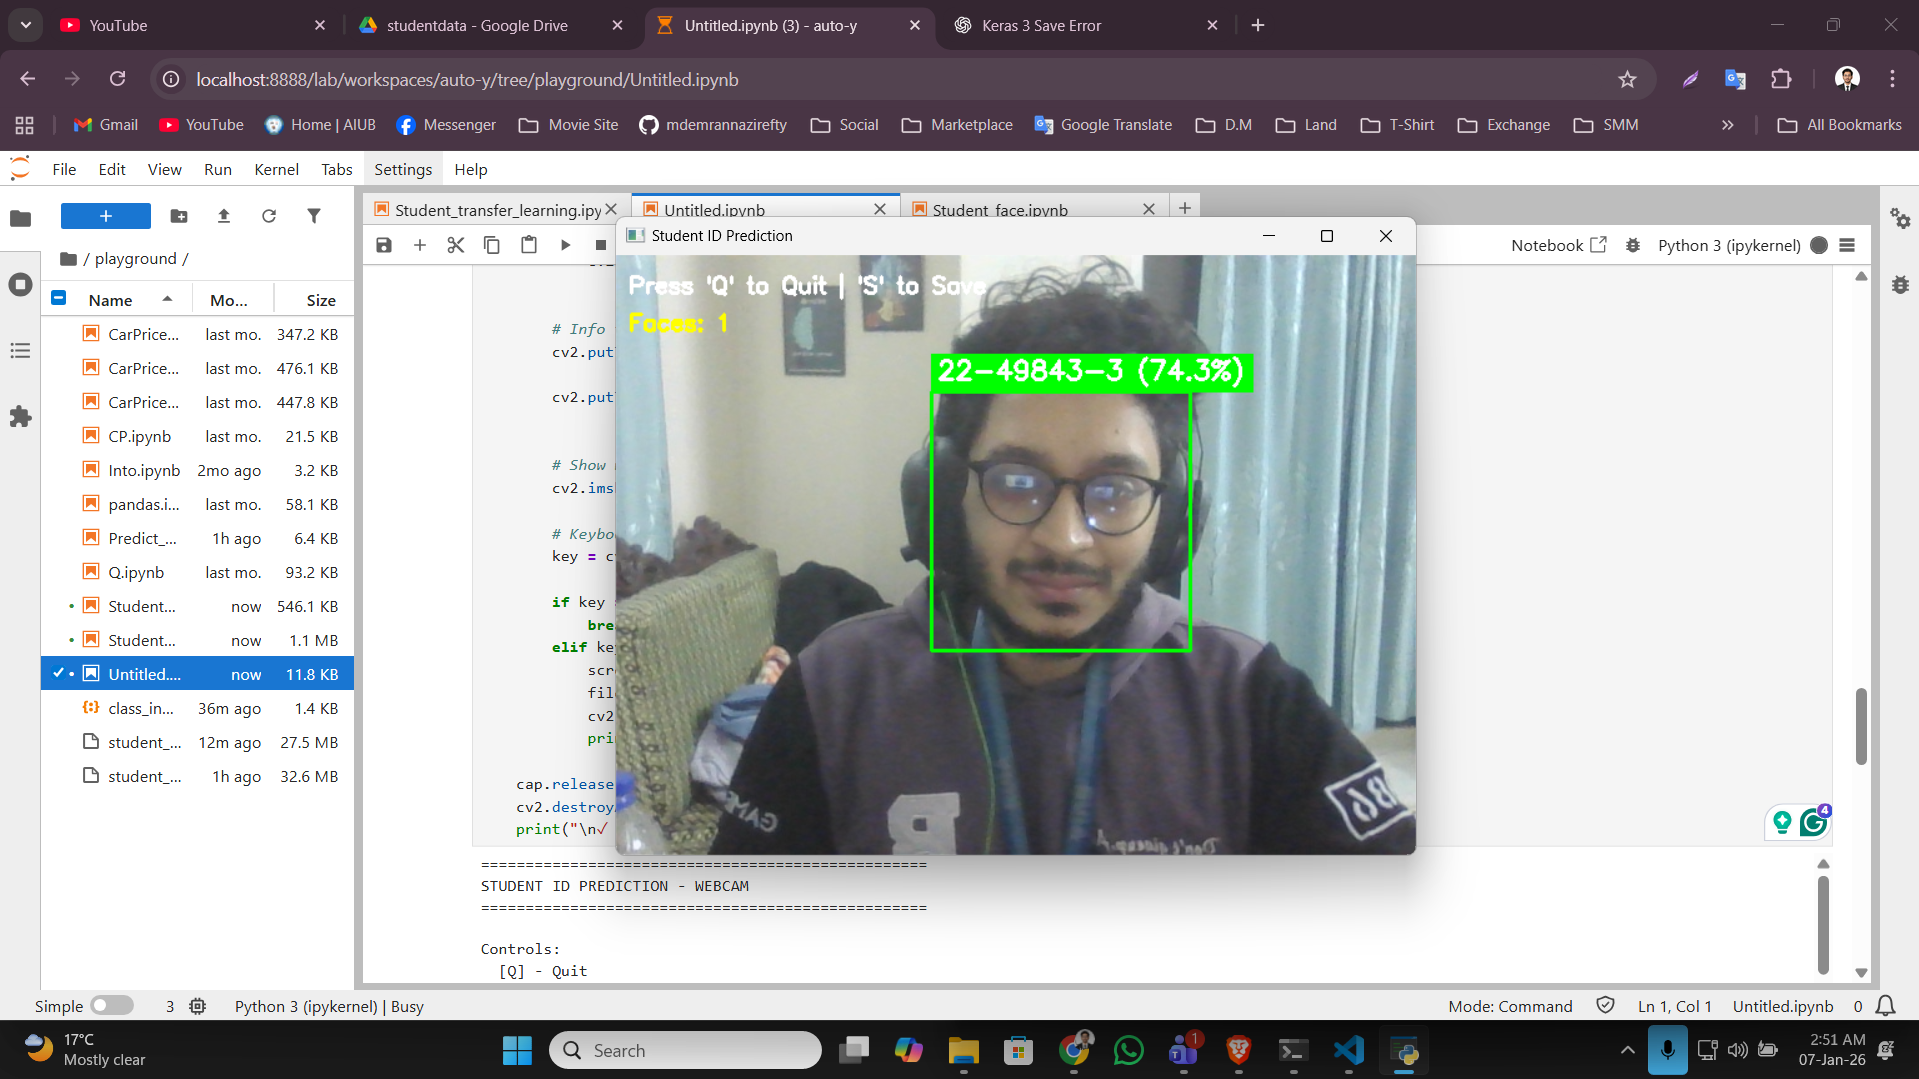